## Importing requried packages

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

## Loading data from google drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
list_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/tablenet_data/Marmot_data/*.xml')

In [6]:
img_height, img_width = 256, 256

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_bmp(img)[:,:,:3]
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def decode_mask_img(img):
  # convert the compressed string to a 2D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
  file_path = tf.strings.regex_replace(file_path, '.xml', '.bmp')

  mask_file_path = tf.strings.regex_replace(file_path, '.bmp', '.jpeg')

  table_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'table_mask')
  column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'column_mask')

  img = normalize(decode_img(tf.io.read_file(file_path)))
  table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))
  column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_file_path)))

  return img, {"table_output" : table_mask, "column_output" : column_mask }

In [ ]:
DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)

train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask', 'Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(256, 256, 3)
(256, 256, 1)


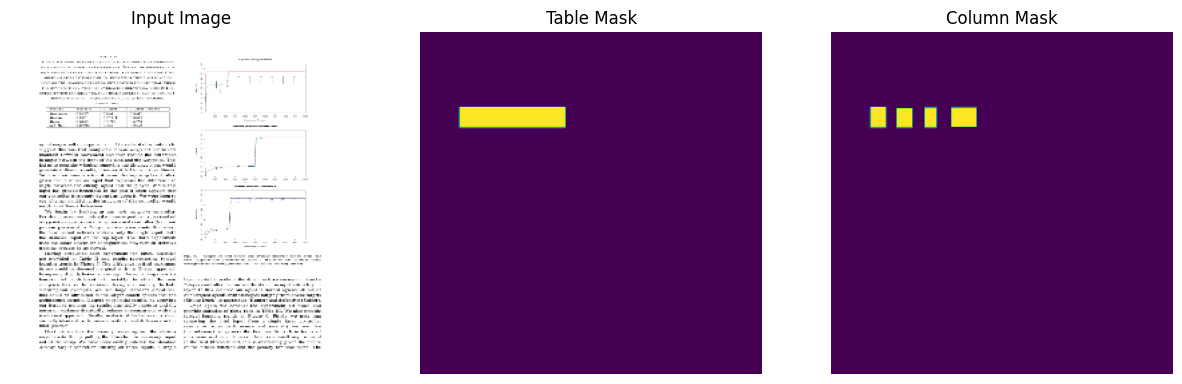

(256, 256, 3)
(256, 256, 1)


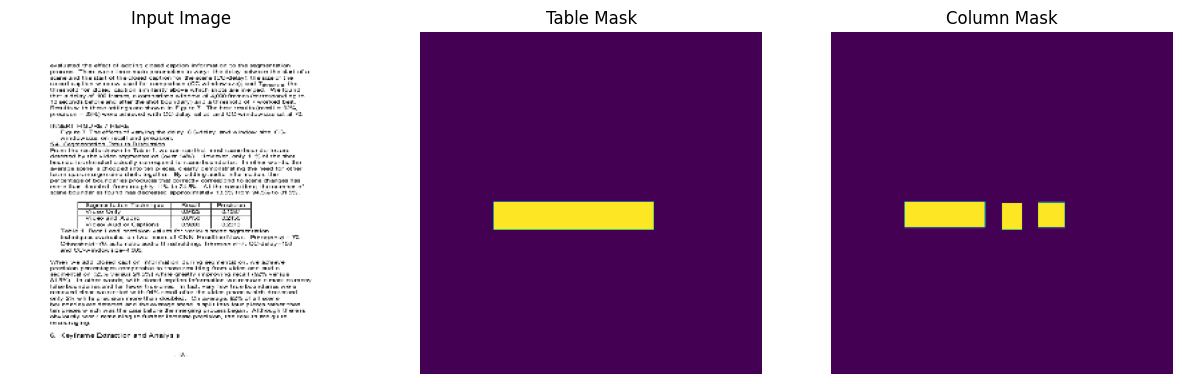

In [ ]:
for image, mask  in train.take(2):
  display([image, mask['table_output'], mask['column_output']])

## Function for generating different models


In [ ]:
class TableNet:
  @staticmethod
  def build_table_decoder(inputs, pool3, pool4, num):
    x = Conv2D(512, (1, 1), activation = 'relu', name='conv7_table')(inputs)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    # concatenated = concatenate([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    if num==3:
      last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same') 
      x = last(x)
      last1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),strides=None,padding='valid', name='table_output')
      x = last1(x)
    else:
      last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same',name='table_output') 
      x = last(x)
    return x
  @staticmethod
  def build_column_decoder(inputs, pool3, pool4, num):
    
    x = Conv2D(512, (1, 1), activation = 'relu', name='block7_conv1_column')(inputs)
    x = Dropout(0.8, name='block7_dropout_column')(x)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block8_conv1_column')(x)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    # concatenated = concatenate([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    
    if num==3:
      last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same') 
      x = last(x)
      last1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),strides=None,padding='valid', name='column_output')
      x = last1(x)
    else:
      last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same',name='column_output') 
      x = last(x)
    return x      

  @staticmethod
  def vgg_base(inputs):
    base_model = tf.keras.applications.vgg19.VGG19(
        input_shape=[256, 256, 3],
        include_top=False, weights='imagenet')
    
    layer_names = ['block3_pool', 'block4_pool', 'block5_pool']
    layers = [base_model.get_layer(name).output for name in layer_names]

    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)
  
  @staticmethod
  def densenet_base(inputs):
    base_model = tf.keras.applications.densenet.DenseNet121(
        input_shape=[256,256,3],
        include_top=False,weights='imagenet')
    
    layer_names = ['pool2_relu', 'pool3_relu', 'pool4_relu']
    layers = [base_model.get_layer(name).output for name in layer_names]
    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)

  @staticmethod
  def resnet_base_1(inputs):
    base_model = tf.keras.applications.resnet50.ResNet50(
        input_shape=[256, 256, 3],
        include_top=False, weights='imagenet')
    
    layer_names = ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
    layers = [base_model.get_layer(name).output for name in layer_names]

    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)

  @staticmethod
  def resnet_base_2(inputs):
    base_model = tf.keras.applications.resnet50.ResNet50(
        input_shape=[256, 256, 3],
        include_top=False, weights='imagenet')
    
    layer_names = ['conv3_block1_1_conv', 'conv4_block1_1_conv', 'conv5_block1_1_conv']
    layers = [base_model.get_layer(name).output for name in layer_names]

    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)
  
  @staticmethod
  def build(num):
    
    if num==0:
      inputShape = (256, 256, 3)
      inputs = Input(shape=inputShape, name='input')
      pool_layers = TableNet.vgg_base(inputs)
    elif num==1:
      inputShape = (256, 256, 3)
      inputs = Input(shape=inputShape, name='input')
      pool_layers= TableNet.resnet_base_1(inputs)
    elif num==2:
      inputShape = (256, 256, 3)
      inputs = Input(shape=inputShape, name='input')
      pool_layers = TableNet.resnet_base_2(inputs)
    elif num==3:
      inputShape = (256, 256, 3)
      inputs = Input(shape=inputShape, name='input')
      pool_layers = TableNet.densenet_base(inputs)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(pool_layers[2])
    x = Dropout(0.8, name='block6_dropout1')(x)
    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
    x = Dropout(0.8, name = 'block6_dropout2')(x)
    
    table_mask = TableNet.build_table_decoder(x, pool_layers[0], pool_layers[1], num)
    column_mask = TableNet.build_column_decoder(x, pool_layers[0], pool_layers[1], num)

    model = Model(			
              inputs=inputs,
			        outputs=[table_mask, column_mask],
			        name="tablenet")
    
    return model

80134624/80134624 [==============================] - 1s 0us/step


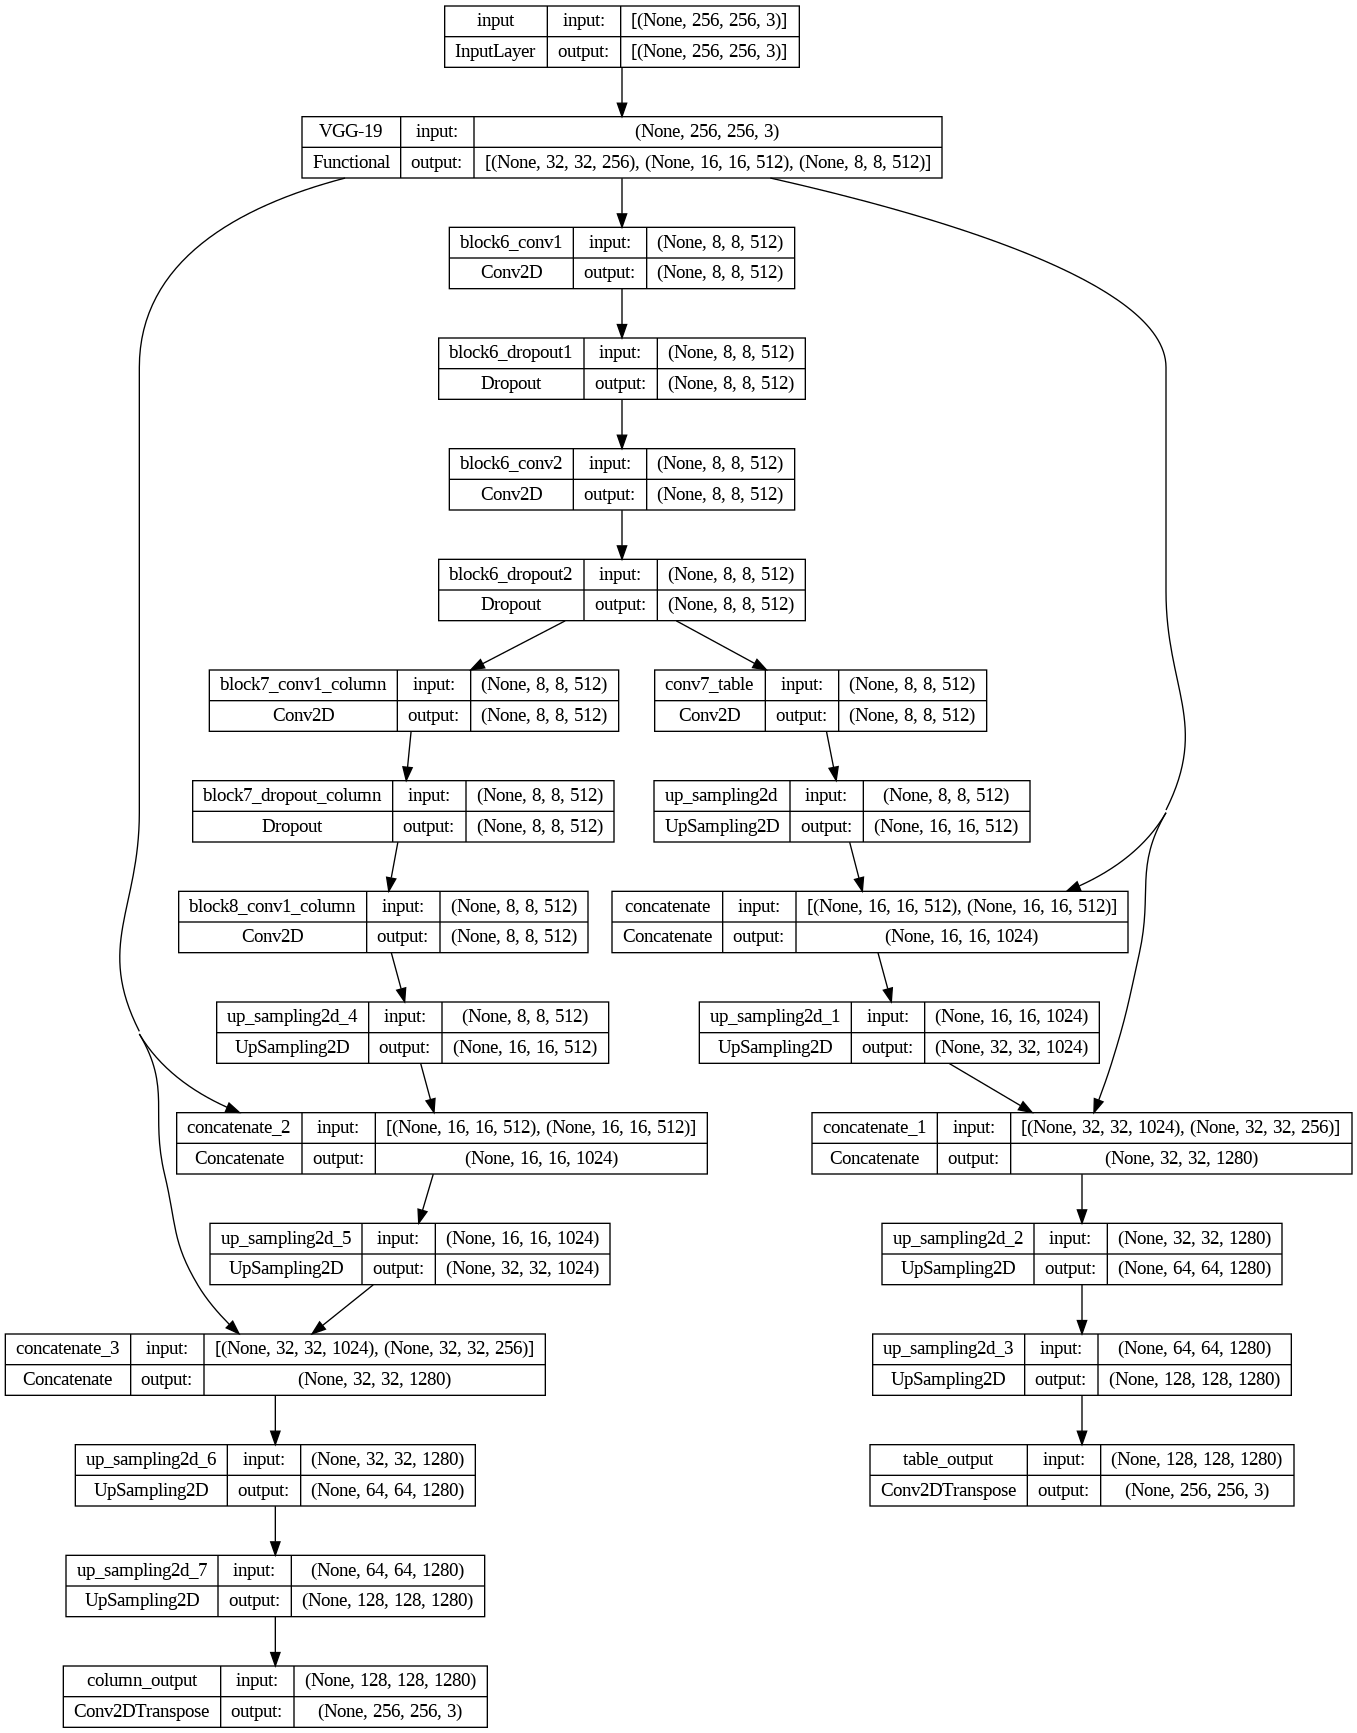

In [ ]:
model_vgg19 = TableNet.build(0)
tf.keras.utils.plot_model(model_vgg19, show_shapes=True)

94765736/94765736 [==============================] - 1s 0us/step


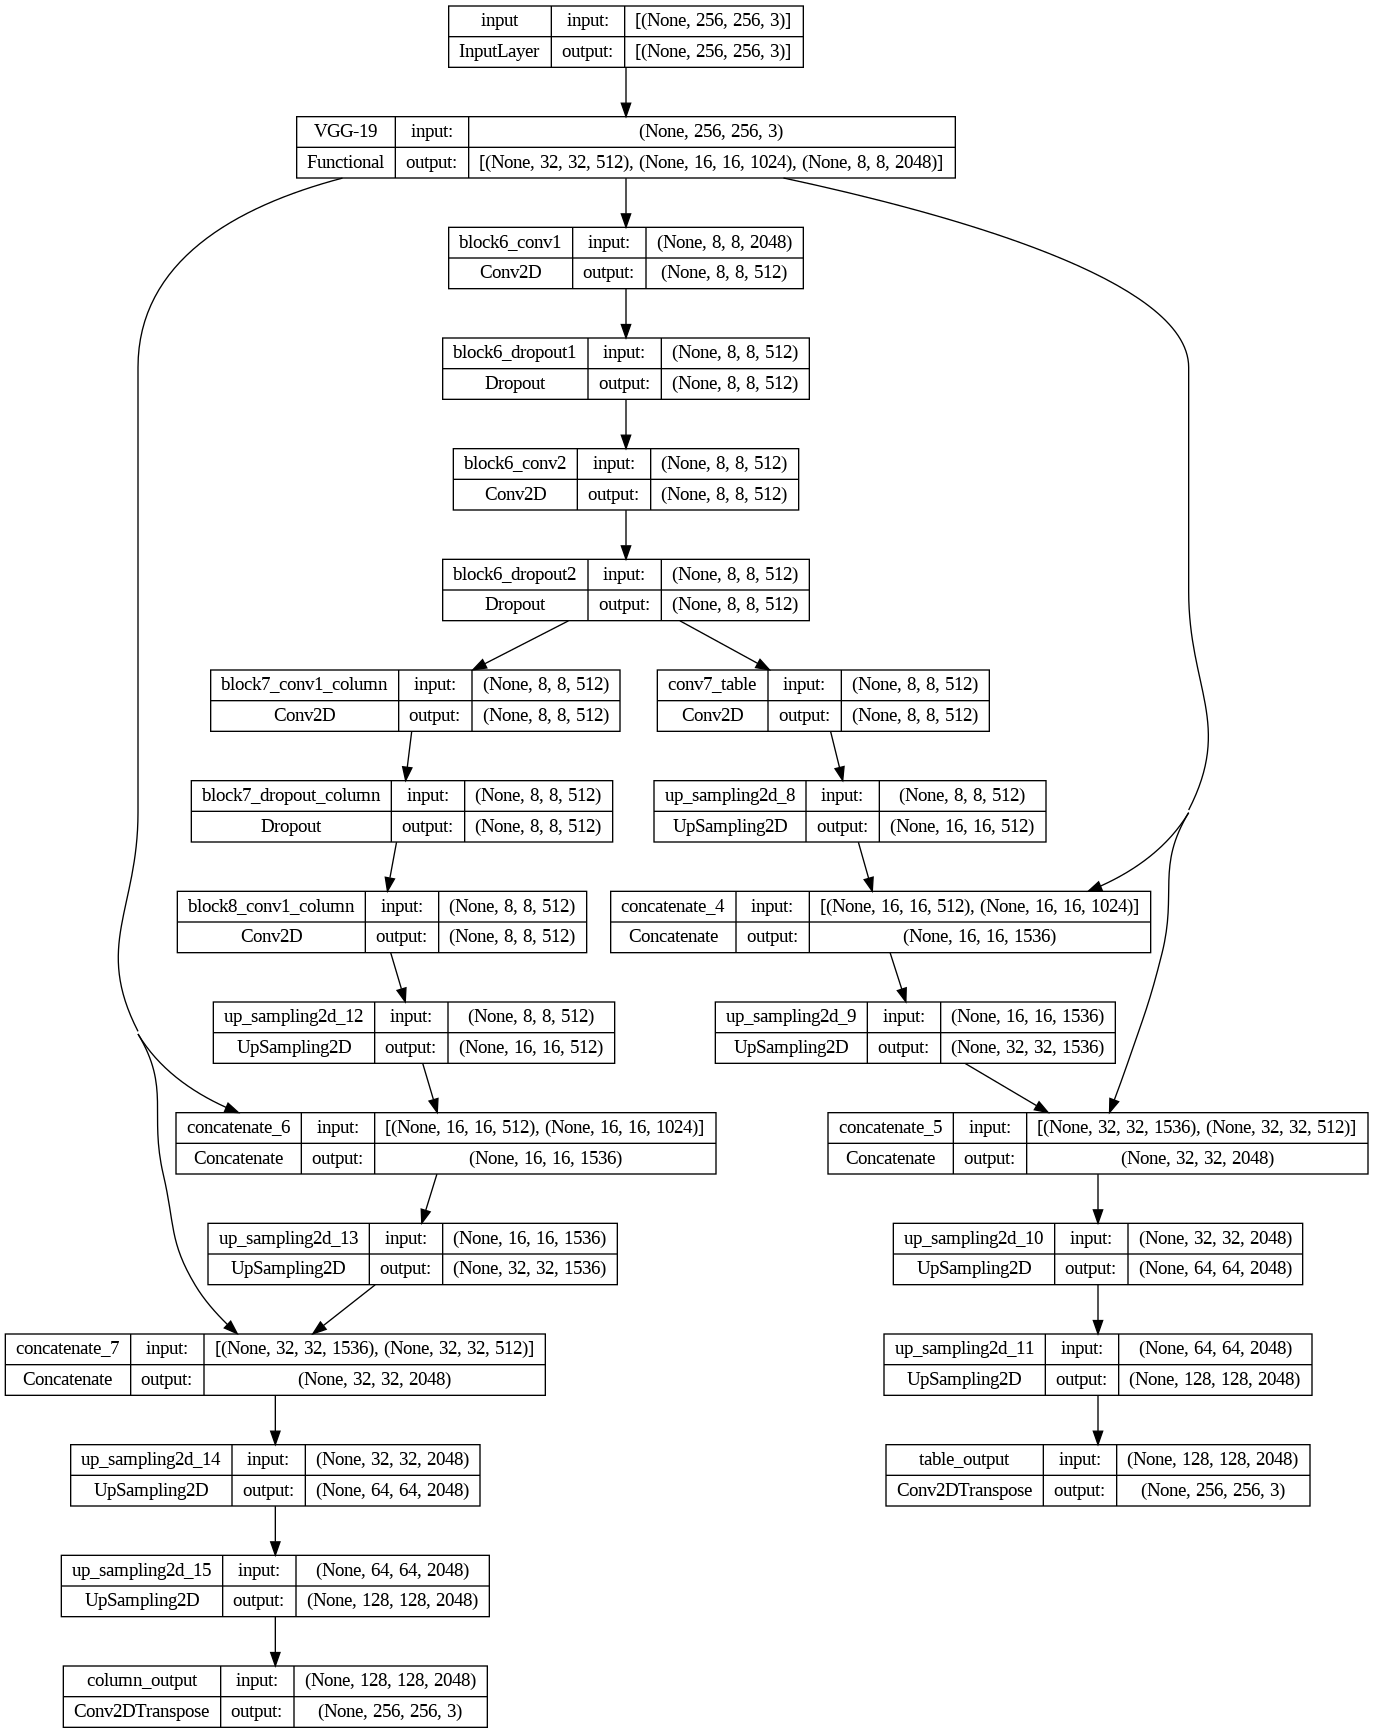

In [ ]:
model_resnet50_1 = TableNet.build(1)
tf.keras.utils.plot_model(model_resnet50_1, show_shapes=True)

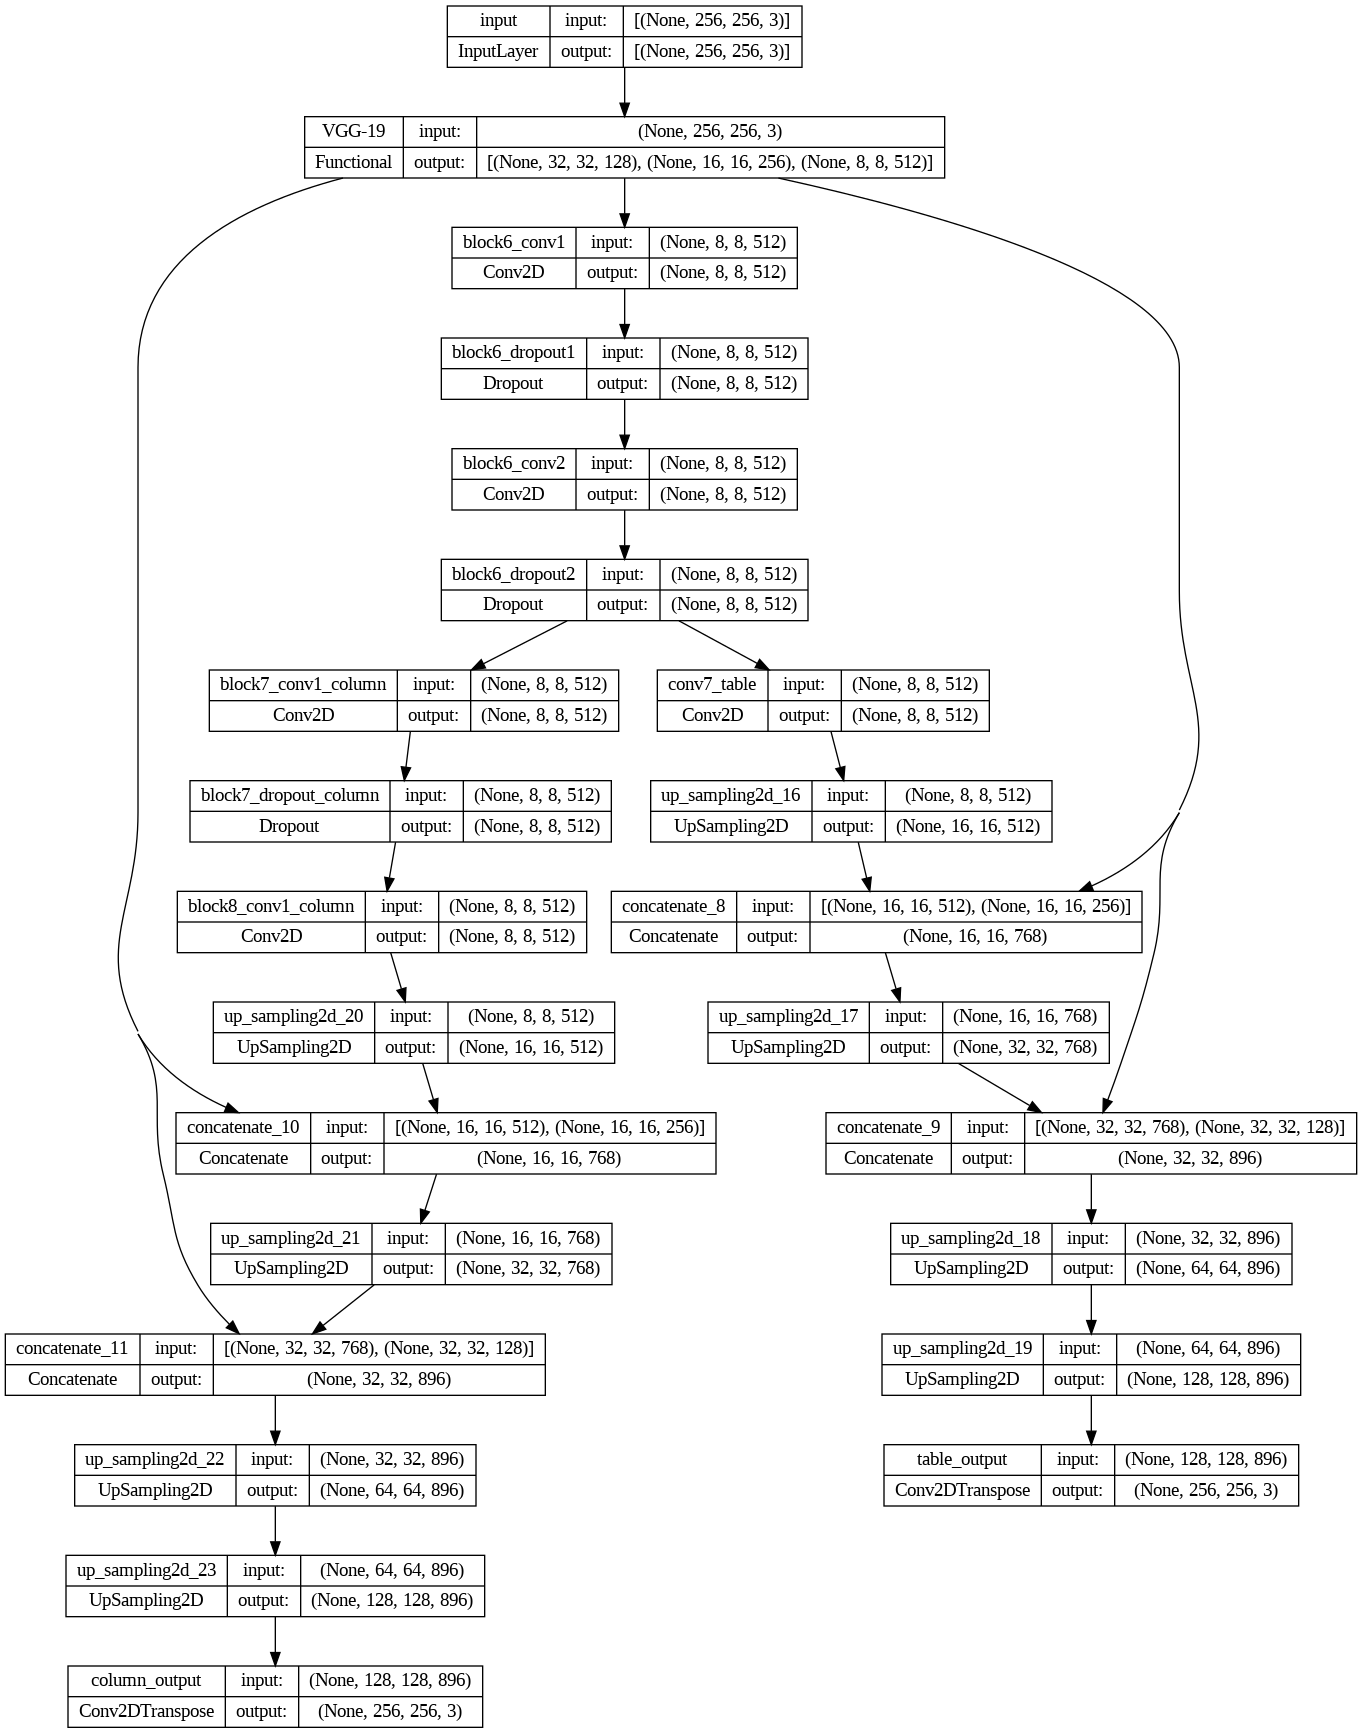

In [ ]:

model_resnet50_2 = TableNet.build(2)
tf.keras.utils.plot_model(model_resnet50_2, show_shapes=True)

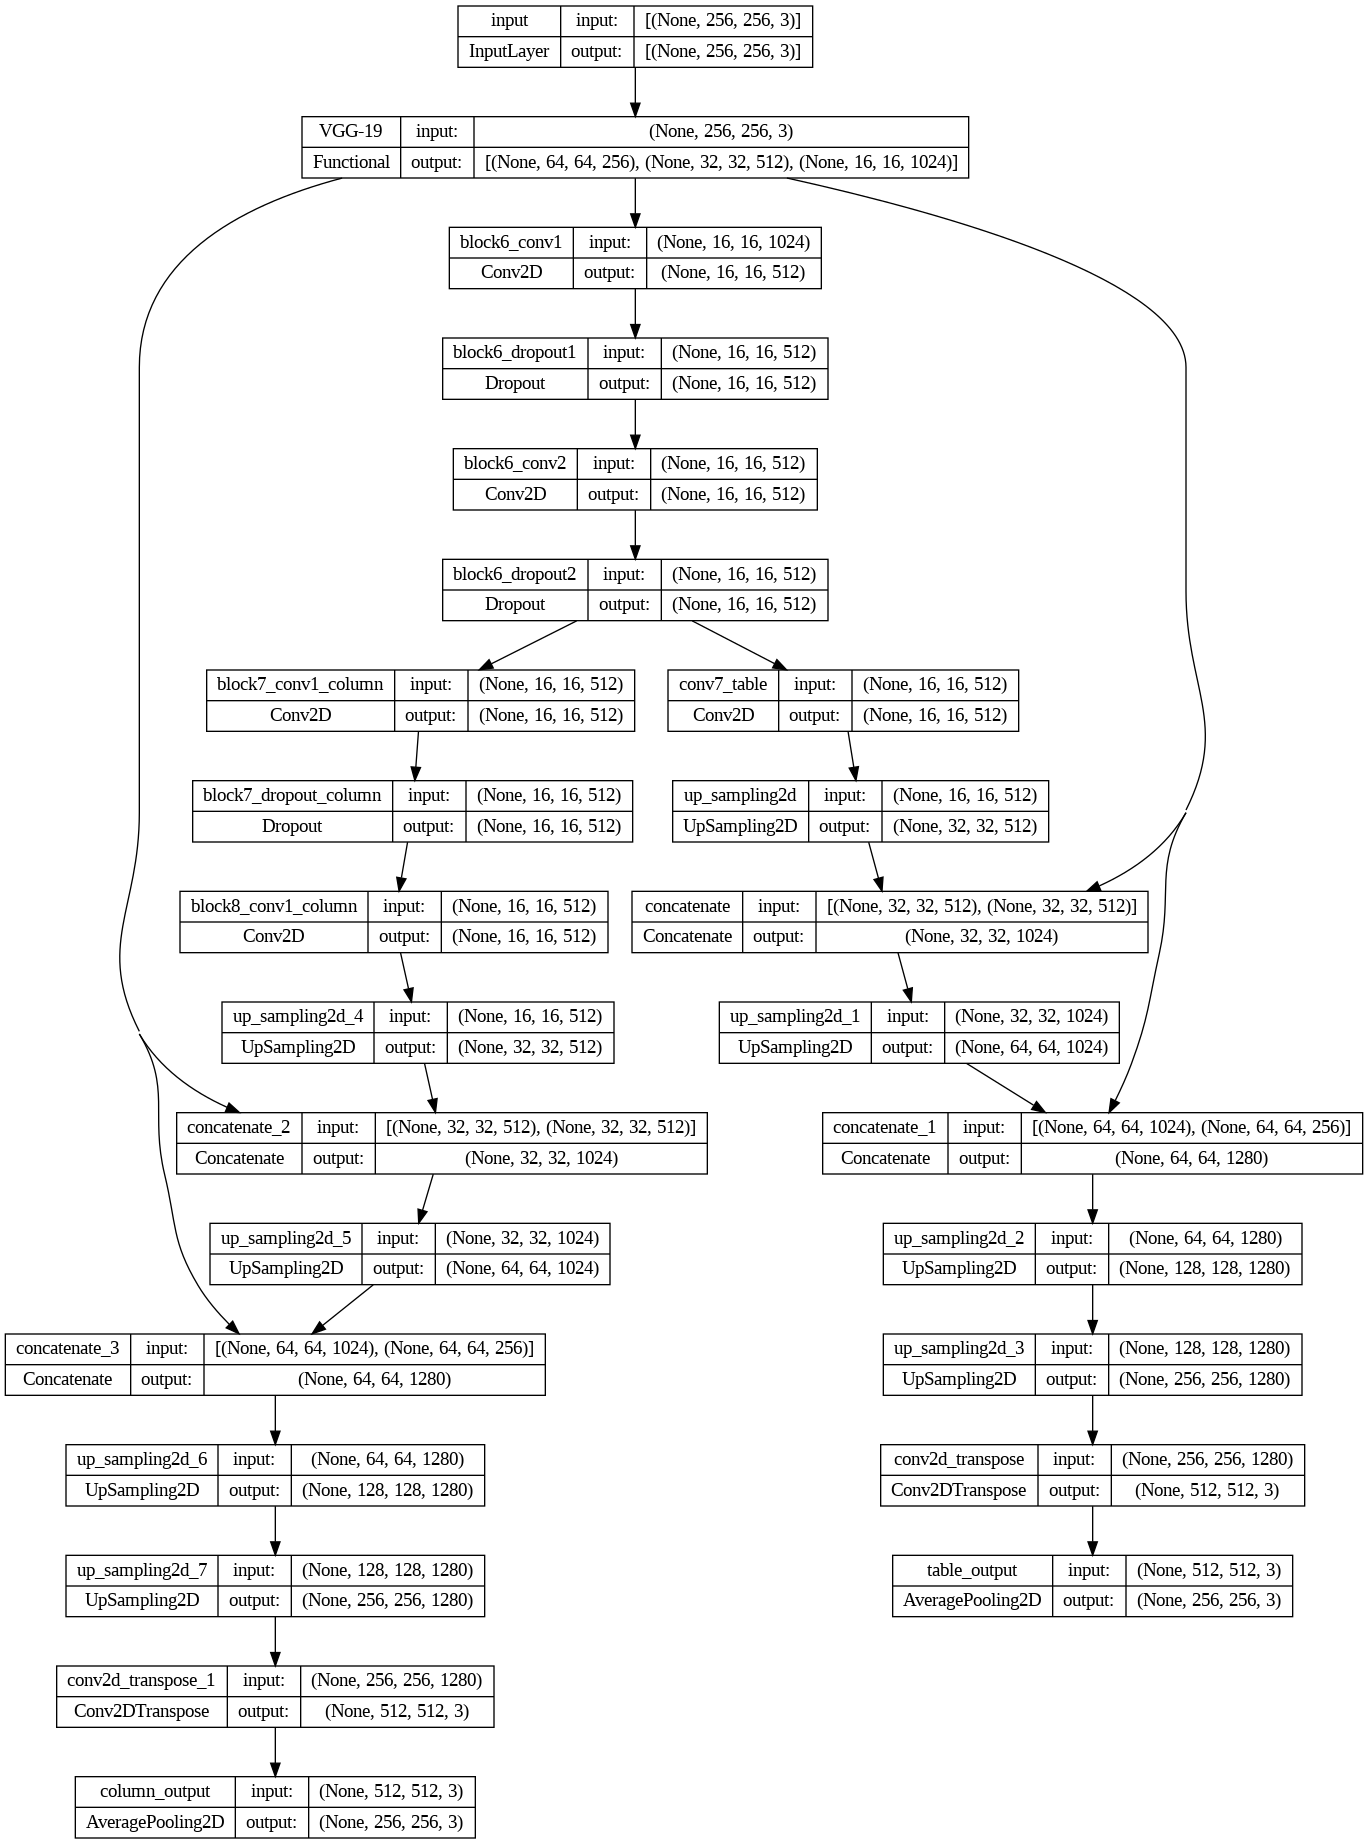

In [ ]:
model_densenet121 = TableNet.build(3)
tf.keras.utils.plot_model(model_densenet121, show_shapes=True)

## Training the models


In [ ]:
losses = {
	"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	"column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}


lossWeights = {"table_output": 1.0, "column_output": 2.0}

model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

model_resnet50_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

model_densenet121.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.1,epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

In [ ]:
EPOCHS = 500
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_vgg19_history = model_vgg19.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=100,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_densenet121_history = model_densenet121.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=100,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

In [ ]:
EPOCHS = 500
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_resnet50_1_history = model_resnet50_1.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=100,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

## Saving and loading models to google drive


In [ ]:
np.save('/content/drive/MyDrive/model_vgg19_history.npy',model_vgg19_history.history)
np.save('/content/drive/MyDrive/model_resnet50_1_history.npy',model_resnet50_1_history.history)
np.save('/content/drive/MyDrive/model02_densenet121_history.npy',model_densenet121_history.history)

In [ ]:
model_vgg19.save('/content/drive/MyDrive/model_vgg19')
model_resnet50_1.save('/content/drive/MyDrive/model_resnet50_1')
model_densenet121.save('/content/drive/MyDrive/model02_densenet121')

In [4]:
model_vgg19=tf.keras.models.load_model('/content/drive/MyDrive/model_vgg19')
model_densenet121=tf.keras.models.load_model('/content/drive/MyDrive/model_densenet121')
model_resnet50_1=tf.keras.models.load_model('/content/drive/MyDrive/model_resnet50_1')
vgg_19=np.load('/content/drive/MyDrive/model_vgg19_history.npy',allow_pickle=True).item()
resnet_50=np.load('/content/drive/MyDrive/model_resnet50_1_history.npy',allow_pickle=True).item()
densenet_121=np.load('/content/drive/MyDrive/model_densenet121_history.npy',allow_pickle=True).item()

In [ ]:
model=np.load('/content/drive/MyDrive/model_densenet121_history.npy',allow_pickle=True).item()
model1=np.load('/content/drive/MyDrive/model1_densenet121_history.npy',allow_pickle=True).item()
model2=np.load('/content/drive/MyDrive/model2_densenet121_history.npy',allow_pickle=True).item()
model3=np.load('/content/drive/MyDrive/model3_densenet121_history.npy',allow_pickle=True).item()
model4=np.load('/content/drive/MyDrive/model4_densenet121_history.npy',allow_pickle=True).item()
model01=np.load('/content/drive/MyDrive/model01_densenet121_history.npy',allow_pickle=True).item()
model02=np.load('/content/drive/MyDrive/model02_densenet121_history.npy',allow_pickle=True).item()

## Hyperparameter tuning for DenseNet121 results


<function matplotlib.pyplot.show(close=None, block=None)>

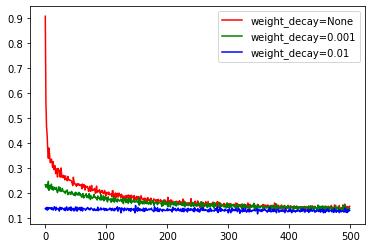

In [ ]:
plt.plot(model['loss'],color='r',label='weight_decay=None') 
plt.plot(model01['loss'],color='g',label='weight_decay=0.001') 
plt.plot(model02['loss'],color='b',label='weight_decay=0.01') 
plt.legend(loc="upper right")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

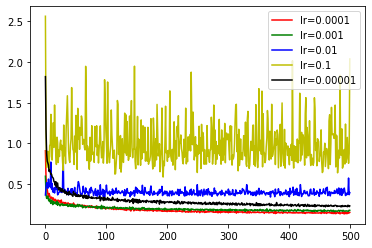

In [ ]:
plt.plot(model['loss'],color='r',label='lr=0.0001') 
plt.plot(model1['loss'],color='g',label='lr=0.001')
plt.plot(model2['loss'],color='b',label='lr=0.01') 
plt.plot(model3['loss'],color='y',label='lr=0.1') 
plt.plot(model4['loss'],color='k',label='lr=0.00001') 
plt.legend(loc="upper right")
plt.show

## Displaying the results for all the models


In [8]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  if(len(display_list)==3):
    title = ['Input Image', 'Table Mask', 'Column Mask']
  else:
    title=['Input Image', 'Table Mask', 'Column Mask','Actual Table Mask','Actual Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [9]:
def create_mask(pred_mask1, pred_mask2):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]
  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = pred_mask2[..., tf.newaxis]
  return pred_mask1[0], pred_mask2[0]

In [ ]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']

def iou_loss(image1,image2,i):
  # IoU calculation
  intersection = np.logical_and(image1, image2)
  union = np.logical_or(image1, image2)
  iou_score = np.sum(intersection) / np.sum(union)
  if i==1:
    print('IoU for table mask output is %s' % iou_score)
  elif i==2:
    print('IoU for column mask output is %s' % iou_score)


def show_predictions_densenet121(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(image.shape)
      pred_mask1, pred_mask2 = model_densenet121.predict(image, verbose=1)
      scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      print("Table loss: "+str(scce(mask['table_output'][0],pred_mask1[0]).numpy()))
      print("Column loss: "+str(scce(mask['column_output'][0],pred_mask2[0]).numpy()))
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      display([image[0], table_mask, column_mask,mask['table_output'][0], mask['column_output'][0]])
  else:
    print(sample_image.shape)
    pred_mask1, pred_mask2 = model_densenet121.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
    iou_loss(sample_mask1[0],table_mask,1)
    iou_loss(sample_mask2[0],column_mask,2)
    display([sample_image[0], table_mask, column_mask,sample_mask1[0], sample_mask2[0]])

def show_predictions_vgg19(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(image.shape)
      pred_mask1, pred_mask2 = model_vgg19.predict(image, verbose=1)
      scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      print("Table loss: "+str(scce(mask['table_output'][0],pred_mask1[0]).numpy()))
      print("Column loss: "+str(scce(mask['column_output'][0],pred_mask2[0]).numpy()))
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      display([image[0], table_mask, column_mask,mask['table_output'][0], mask['column_output'][0]])
  else:
    pred_mask1, pred_mask2 = model_vgg19.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
    iou_loss(sample_mask1[0],table_mask,1)
    iou_loss(sample_mask2[0],column_mask,2)
    display([sample_image[0], table_mask, column_mask, sample_mask1[0], sample_mask2[0]])

def show_predictions_resnet50_1(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(image.shape)
      pred_mask1, pred_mask2 = model_resnet50_1.predict(image, verbose=1)
      scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      print("Table loss: "+str(scce(mask['table_output'][0],pred_mask1[0]).numpy()))
      print("Column loss: "+str(scce(mask['column_output'][0],pred_mask2[0]).numpy()))
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      display([image[0], table_mask, column_mask])
  else:
    pred_mask1, pred_mask2 = model_resnet50_1.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
    iou_loss(sample_mask1[0],table_mask,1)
    iou_loss(sample_mask2[0],column_mask,2)
    display([sample_image[0], table_mask, column_mask,sample_mask1[0], sample_mask2[0]])

print("##############################################################################################################################")
print("Results for DENSENET121")
show_predictions_densenet121()
print("##############################################################################################################################")
print("Results for VGG19")
show_predictions_vgg19()
print("##############################################################################################################################")
print("Results for RESNET50")
show_predictions_resnet50_1()
print("##############################################################################################################################")

<function matplotlib.pyplot.show(close=None, block=None)>

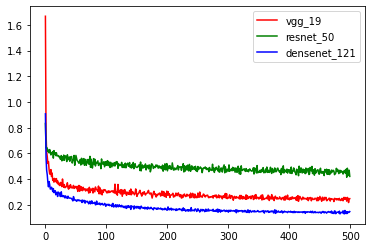

In [ ]:
plt.plot(vgg_19['loss'],color='r',label='vgg_19') 
plt.plot(resnet_50['loss'],color='g',label='resnet_50')
plt.plot(densenet_121['loss'],color='b',label='densenet_121')
plt.legend(loc="upper right")
plt.show

## Comparison of IoU values obtained for all models

In [ ]:
def iou_loss1(image1,image2):
  # IoU calculation
  intersection = np.logical_and(image1, image2)
  union = np.logical_or(image1, image2)
  iou_score = np.sum(intersection) / np.sum(union)
  return iou_score

iou_table = 0
iou_column = 0
i = 0
for image, mask in test_dataset:
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']
  pred_mask1, pred_mask2 = model_densenet121.predict(sample_image, verbose=0)
  table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
  iou_table += iou_loss1(sample_mask1[0],table_mask)
  iou_column += iou_loss1(sample_mask2[0],column_mask)
  i += 1
print("IOU value for DENSENET121 for table mask: "+str(iou_table/i))
print("IOU value for DENSENET121 for column mask: "+str(iou_column/i))

iou_table = 0
iou_column = 0
i = 0
for image, mask in test_dataset:
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']
  pred_mask1, pred_mask2 = model_vgg19.predict(sample_image, verbose=0)
  table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
  iou_table += iou_loss1(sample_mask1[0],table_mask)
  iou_column += iou_loss1(sample_mask2[0],column_mask)
  i += 1
print("IOU value for VGG19 for table mask: "+str(iou_table/i))
print("IOU value for VGG19 for column mask: "+str(iou_column/i))

iou_table = 0
iou_column = 0
i = 0
for image, mask in test_dataset:
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']
  pred_mask1, pred_mask2 = model_resnet50_1.predict(sample_image, verbose=0)
  table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
  iou_table += iou_loss1(sample_mask1[0],table_mask)
  iou_column += iou_loss1(sample_mask2[0],column_mask)
  i += 1
print("IOU value for RESNET50 for table mask: "+str(iou_table/i))
print("IOU value for RESNET50 for column mask: "+str(iou_column/i))

IOU value for DENSENET121 for table mask: 0.8366942116295703
IOU value for DENSENET121 for column mask: 0.7180963827166653
IOU value for VGG19 for table mask: 0.6672252417143872
IOU value for VGG19 for column mask: 0.5035311767463762
IOU value for RESNET50 for table mask: 0.3582169658179831
IOU value for RESNET50 for column mask: 0.17686756757839056


## Evaluating the models on sample pdfs provided


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  if(len(display_list)==3):
    title = ['Input Image', 'Table Mask', 'Column Mask']
  else:
    title=['Input Image', 'Table Mask', 'Column Mask','Actual Table Mask','Actual Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 46ms/step


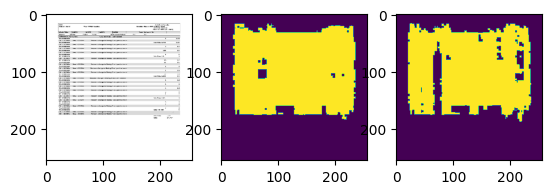

1/1 [==============================] - 0s 27ms/step


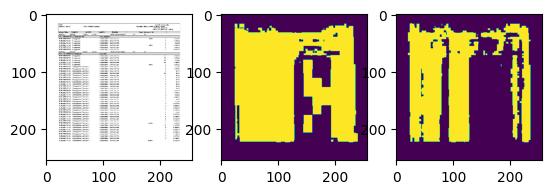

1/1 [==============================] - 0s 35ms/step


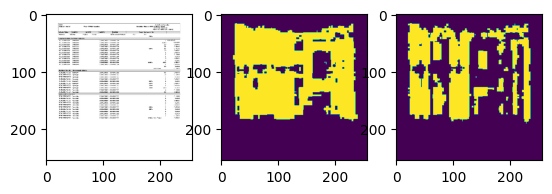

1/1 [==============================] - 0s 29ms/step


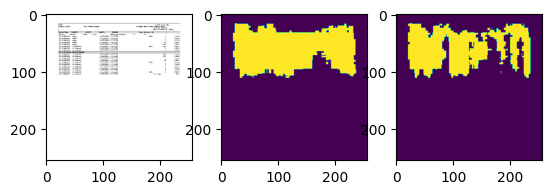

1/1 [==============================] - 0s 29ms/step


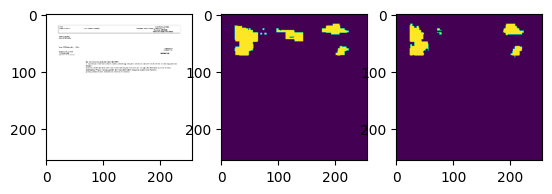

1/1 [==============================] - 0s 32ms/step


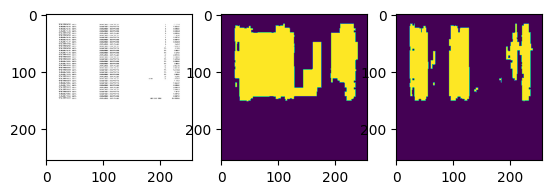

1/1 [==============================] - 0s 30ms/step


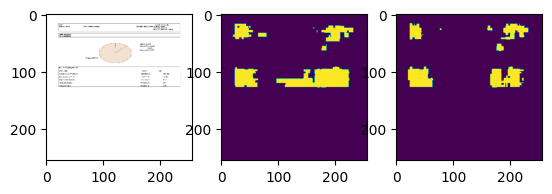

1/1 [==============================] - 0s 28ms/step


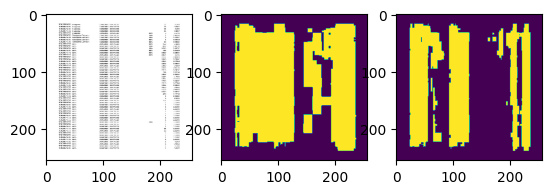

In [ ]:
import cv2
import os

def show_results(path):
  plt.figure(figsize=(15, 15))
  sample_image = cv2.imread(path)
  sample_image = cv2.resize(sample_image, (256, 256))
  sample_image1 = sample_image
  sample_image = normalize(sample_image)
  sample_image = sample_image[None,:]
  pred_mask1, pred_mask2 = model_densenet121.predict(sample_image, verbose=1)
  table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
  f = plt.figure()
  f.add_subplot(1,3, 1)
  plt.imshow(sample_image1)
  f.add_subplot(1,3, 2)
  plt.imshow(table_mask)
  f.add_subplot(1,3, 3)
  plt.imshow(column_mask)
  plt.axis('off')
  plt.show(block=True)

arr = os.listdir('/content/File3')
for file0 in arr:
  show_results(str('/content/File3/') + file0)

1/1 [==============================] - 0s 26ms/step


<Figure size 1500x1500 with 0 Axes>

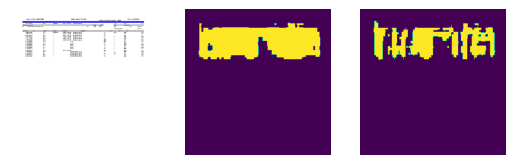

1/1 [==============================] - 0s 40ms/step


<Figure size 1500x1500 with 0 Axes>

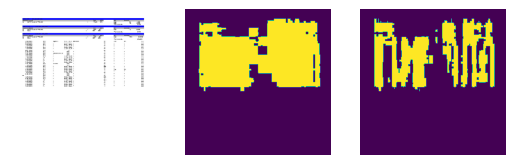

1/1 [==============================] - 0s 58ms/step


<Figure size 1500x1500 with 0 Axes>

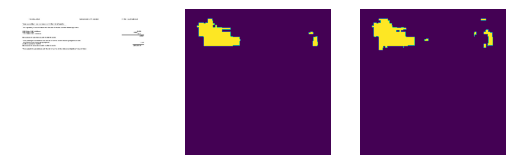

1/1 [==============================] - 0s 50ms/step


<Figure size 1500x1500 with 0 Axes>

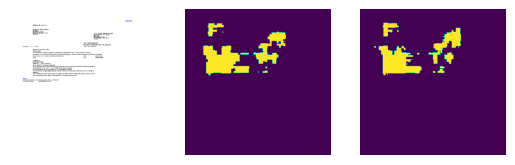

1/1 [==============================] - 0s 43ms/step


<Figure size 1500x1500 with 0 Axes>

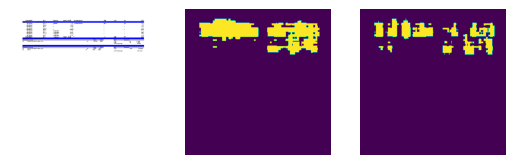

1/1 [==============================] - 0s 39ms/step


<Figure size 1500x1500 with 0 Axes>

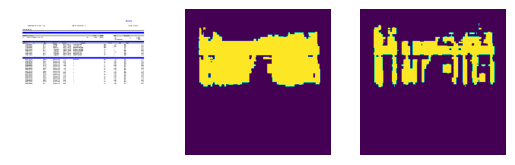

1/1 [==============================] - 0s 52ms/step


<Figure size 1500x1500 with 0 Axes>

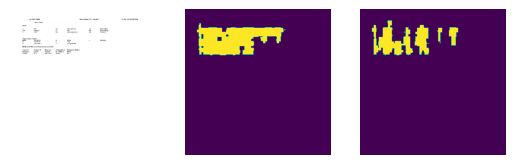

1/1 [==============================] - 0s 43ms/step


<Figure size 1500x1500 with 0 Axes>

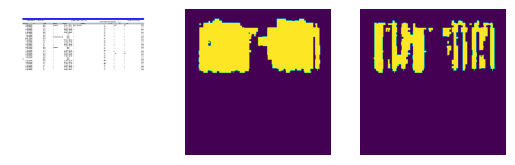

1/1 [==============================] - 0s 48ms/step


<Figure size 1500x1500 with 0 Axes>

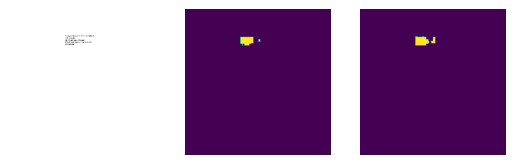

In [14]:
import cv2
import os

def show_results(path):
  plt.figure(figsize=(15, 15))
  sample_image = cv2.imread(path)
  sample_image = cv2.resize(sample_image, (256, 256))
  sample_image1 = sample_image
  sample_image = normalize(sample_image)
  sample_image = sample_image[None,:]
  pred_mask1, pred_mask2 = model_densenet121.predict(sample_image, verbose=1)
  table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
  f = plt.figure()
  f.add_subplot(1,3,1)
  plt.imshow(sample_image1)
  plt.axis('off')
  f.add_subplot(1,3, 2)
  plt.imshow(table_mask)
  plt.axis('off')
  f.add_subplot(1,3, 3)
  plt.imshow(column_mask)
  plt.axis('off')
  plt.show(block=True)

arr = os.listdir('/content/File1')
for file0 in arr:
  show_results(str('/content/File1/') + file0)